## Step 3: Simulate Pattern Completion
Run: Input vector starts at r=20 (high drift); geodesic applies rule, warping locks to correct (e.g., [0,1,1,0]), flat zigzags to wrong. Output: Prints transformed grid, plots paths in R3 with funnel.

In [ ]:
# Geodesic in well (warped space)
def geodesic_eqs(y, t, M, r_scale, R, target):
    x, dx = y[:4], y[4:]  # R4 position and velocity
    r = np.sqrt(np.sum(x**2)) + 1e-6
    M_eff = M * (1 / (1 + r / r_scale))  # Position-dependent mass
    factor = 1 - 2 * M_eff / r
    # Acceleration: Warping toward origin + incremental rotation + pull to target
    d2x = -M_eff * x / r**3 * factor + 0.01 * (R @ x - x) + 0.2 * M_eff * (target - x) / np.linalg.norm(target - x + 1e-6)
    return np.concatenate([dx, d2x])

# Project R4 to R3 for visualization (PCA on time series)
def project_to_r3(r4_data):
    pca = PCA(n_components=3)
    projected = pca.fit_transform(r4_data)  # Fit on (num_timesteps, 4)
    return projected

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
from scipy.integrate import odeint

# Simulate ARC-like grid transformations with diversity
def create_arc_data(num_samples=600):
    data = []
    for _ in range(num_samples // 6):
        a, b, c, d = np.random.choice(range(1, 10), size=4, replace=False)
        # Rotation
        data.append(([a, b, c, d], [c, a, d, b], 1))
        # Mirror
        data.append(([a, b, c, d], [b, a, d, c], 1))
        # Flip
        data.append(([a, b, c, d], [d, c, b, a], 1))
        # Wrong (resize fail)
        data.append(([a, b, c, d], [a, b], 0))
        # Wrong (color swap fail)
        data.append(([a, b, c, d], [b, a, d, c + 1], 0))
        # Wrong (random)
        data.append(([a, b, c, d], [np.random.randint(1, 10), np.random.randint(1, 10), np.random.randint(1, 10), np.random.randint(1, 10)], 0))
    return data

# Compute position-aware custom features
def compute_custom_features(grid):
    if len(grid) == 4:
        pos_weights = np.array([1, 2, 3, 4])
        weighted_sum = np.sum(grid * pos_weights)
        weighted_product = np.prod(grid * pos_weights)
        return [weighted_sum, weighted_product, np.max(grid), np.min(grid), np.median(grid), np.var(grid)]
    else:
        pos_weights = np.array([1, 2])
        weighted_sum = np.sum(grid * pos_weights)
        weighted_product = np.prod(grid * pos_weights)
        return [weighted_sum, weighted_product, np.max(grid), np.min(grid), np.median(grid), np.var(grid)]

# Project to 3D with PCA on custom features
def project_to_3d(grid, pca):
    custom_features = compute_custom_features(grid)
    projected = pca.transform(np.array([custom_features]))[0]
    return projected.tolist()

# Funnel Well with Logarithmic Curvature
class FunnelWell:
    def __init__(self, k=50.0):
        self.k = k

    def potential(self, r):
        return -self.k * np.log(1 + r + 1e-6)

    def geodesic_distance(self, x1, x2):
        r1 = np.linalg.norm(x1)
        r2 = np.linalg.norm(x2)
        z1 = self.potential(r1)
        z2 = self.potential(r2)
        return np.sqrt((r1 - r2) ** 2 + (z1 - z2) ** 2) + 1e-3  # Larger epsilon

# Prepare PCA with all custom features
data = create_arc_data()
all_features = np.array([compute_custom_features(item[0]) for item in data])  # 600x6 matrix
pca = PCA(n_components=3)
pca.fit(all_features)

# Simulate and Visualize
well = FunnelWell(k=50.0)
correct_paths = []
wrong_paths = []
correct_dists = []
wrong_dists = []

for input_grid, target_grid, label in data:
    input_3d = project_to_3d(input_grid, pca)
    target_3d = project_to_3d(target_grid, pca)
    dist = well.geodesic_distance(input_3d, target_3d)
    if label == 1:
        correct_paths.append((input_3d, target_3d, dist))
        correct_dists.append(dist)
    else:
        wrong_paths.append((input_3d, target_3d, dist))
        wrong_dists.append(dist)

# Dynamic Threshold (mean(correct) + 2 * std(correct))
if correct_dists:
    threshold = np.mean(correct_dists) + 2 * np.std(correct_dists)
else:
    threshold = 1.0

# Visualization
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for input_3d, target_3d, dist in correct_paths:
    ax.plot([input_3d[0], target_3d[0]], [input_3d[1], target_3d[1]], [input_3d[2], target_3d[2]], 'b-', label='Correct' if not ax.lines else "")
    ax.scatter([target_3d[0]], [target_3d[1]], [target_3d[2]], c='b', marker='o')
for input_3d, target_3d, dist in wrong_paths:
    ax.plot([input_3d[0], target_3d[0]], [input_3d[1], target_3d[1]], [input_3d[2], target_3d[2]], 'r-', label='Wrong' if not ax.lines else "")
    ax.scatter([target_3d[0]], [target_3d[1]], [target_3d[2]], c='r', marker='x')

# Well Surface
r = np.linspace(0, 2, 100)
theta = np.linspace(0, 2 * np.pi, 100)
r, theta = np.meshgrid(r, theta)
x = r * np.cos(theta)
y = r * np.sin(theta)
z = well.potential(r)
ax.plot_surface(x, y, z, color='green', alpha=0.5)

ax.set_xlabel('PCA1')
ax.set_ylabel('PCA2')
ax.set_zlabel('PCA3')
ax.set_title('Sharpened Logarithmic Cognition Well (k=50.0)')
plt.legend()
plt.show()

# Evaluate Accuracy
correct_count = sum(1 for _, _, dist in correct_paths if dist < threshold)
wrong_count = sum(1 for _, _, dist in wrong_paths if dist > threshold)
total = len(data)
accuracy = (correct_count + wrong_count) / total
print(f"Accuracy: {accuracy * 100:.2f}% with threshold={threshold:.4f}")
print(f"Correct Paths Count: {len(correct_paths)}, Wrong Paths Count: {len(wrong_paths)}")
print(f"Distance Stats - Min: {min(correct_dists + wrong_dists):.4f}, Max: {max(correct_dists + wrong_dists):.4f}, Mean: {np.mean(correct_dists + wrong_dists):.4f}")
# Histogram for distances
plt.hist(correct_dists, bins=20, alpha=0.5, label='Correct')
plt.hist(wrong_dists, bins=20, alpha=0.5, label='Wrong')
plt.axvline(threshold, color='k', linestyle='dashed', linewidth=1)
plt.legend()
plt.title('Distance Histogram with Threshold')
plt.show()

# Step 3: Simulate Pattern Completion
# Input vector starts at r=20 (high drift)
initial_r = 20.0
input_vector = initial_r * np.random.randn(4)  # Start at high r
target = np.array([0, 1, 1, 0])  # Example correct output
y0 = np.concatenate([input_vector, [0.05, 0.05, 0.05, 0.05]])  # Initial velocity

# Parameters
M = 15.0  # Semantic mass
r_scale = 15.0  # Scale for stability
t = np.linspace(0, 100, 2000)  # Longer time range

# Dynamic Operator: 90° clockwise rotation matrix for R4 vector
R = np.array([
    [0, 0, 1, 0],
    [1, 0, 0, 0],
    [0, 0, 0, 1],
    [0, 1, 0, 0]
])

# Solve geodesic with rule applied (warping)
sol_warp = odeint(geodesic_eqs, y0, t, args=(M, r_scale, R, target))
x_warp = sol_warp[:, :4]

# Flat space (M=0, no rotation)
sol_flat = odeint(geodesic_eqs, y0, t, args=(0, r_scale, np.eye(4), target))
x_flat = sol_flat[:, :4]

# Print transformed grid (final warped position)
transformed_grid = x_warp[-1]
print("Transformed Grid (Warped):", transformed_grid)

# Project to R3 for visualization
x_warp_r3 = project_to_r3(x_warp)
x_flat_r3 = project_to_r3(x_flat)

# Add noise to flat for zigzag
np.random.seed(42)
noise = np.random.normal(0, 0.05, size=(len(t), 3))
x_flat_r3 += np.cumsum(noise, axis=0)

# Plot paths in R3 with funnel
fig = plt.figure(figsize=(12, 9))
ax = fig.add_subplot(111, projection='3d')
# Funnel surface
u = np.linspace(0, 2 * np.pi, 50)
v = np.linspace(0.01, 50, 50)
U, V = np.meshgrid(u, v)
X = V * np.cos(U)
Y = V * np.sin(U)
Z = well.potential(V)
ax.plot_surface(X, Y, Z, cmap='viridis', alpha=0.4, rstride=5, cstride=5)

ax.plot(x_warp_r3[:, 0], x_warp_r3[:, 1], x_warp_r3[:, 2], 'b-', label='Warped (Locks to Correct)')
ax.plot(x_flat_r3[:, 0], x_flat_r3[:, 1], x_flat_r3[:, 2], 'r--', label='Flat (Zigzags to Wrong)')
ax.scatter(0, 0, 0, color='g', s=150, label='Noetic Singularity (Correct Decode)')
ax.scatter(x_flat_r3[-1, 0], x_flat_r3[-1, 1], x_flat_r3[-1, 2], color='y', s=150, label='Wrong Position')
ax.scatter(x_warp_r3[0, 0], x_warp_r3[0, 1], x_warp_r3[0, 2], color='c', s=150, label='Input Start')
ax.set_xlabel('PCA1')
ax.set_ylabel('PCA2')
ax.set_zlabel('PCA3')
ax.set_title('Pattern Completion Simulation in R3 with Funnel Well')
ax.legend()
ax.view_init(elev=30, azim=45)
plt.tight_layout()
plt.savefig('pattern_completion.png')  # Save for repo
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
from scipy.integrate import odeint

# Geodesic in well (warped space)
def geodesic_eqs(y, t, M, r_scale, R, target):
    x, dx = y[:4], y[4:]  # R4 position and velocity
    r = np.sqrt(np.sum(x**2)) + 1e-6
    M_eff = M * (1 / (1 + r / r_scale))  # Position-dependent mass
    factor = 1 - 2 * M_eff / r
    # Acceleration: Warping toward origin + incremental rotation + pull to target
    d2x = -M_eff * x / r**3 * factor + 0.01 * (R @ x - x) + 0.2 * M_eff * (target - x) / np.linalg.norm(target - x + 1e-6)
    return np.concatenate([dx, d2x])

# Project R4 to R3 for visualization (PCA on time series)
def project_to_r3(r4_data):
    pca = PCA(n_components=3)
    projected = pca.fit_transform(r4_data)  # Fit on (num_timesteps, 4)
    return projected

# Simulate ARC-like grid transformations with diversity
def create_arc_data(num_samples=600):
    data = []
    for _ in range(num_samples // 6):
        a, b, c, d = np.random.choice(range(1, 10), size=4, replace=False)
        # Rotation
        data.append(([a, b, c, d], [c, a, d, b], 1))
        # Mirror
        data.append(([a, b, c, d], [b, a, d, c], 1))
        # Flip
        data.append(([a, b, c, d], [d, c, b, a], 1))
        # Wrong (resize fail)
        data.append(([a, b, c, d], [a, b], 0))
        # Wrong (color swap fail)
        data.append(([a, b, c, d], [b, a, d, c + 1], 0))
        # Wrong (random)
        data.append(([a, b, c, d], [np.random.randint(1, 10), np.random.randint(1, 10), np.random.randint(1, 10), np.random.randint(1, 10)], 0))
    return data

# Compute position-aware custom features
def compute_custom_features(grid):
    if len(grid) == 4:
        pos_weights = np.array([1, 2, 3, 4])
        weighted_sum = np.sum(grid * pos_weights)
        weighted_product = np.prod(grid * pos_weights)
        return [weighted_sum, weighted_product, np.max(grid), np.min(grid), np.median(grid), np.var(grid)]
    else:
        pos_weights = np.array([1, 2])
        weighted_sum = np.sum(grid * pos_weights)
        weighted_product = np.prod(grid * pos_weights)
        return [weighted_sum, weighted_product, np.max(grid), np.min(grid), np.median(grid), np.var(grid)]

# Project to 3D with PCA on custom features
def project_to_3d(grid, pca):
    custom_features = compute_custom_features(grid)
    projected = pca.transform(np.array([custom_features]))[0]
    return projected.tolist()

# Funnel Well with Logarithmic Curvature
class FunnelWell:
    def __init__(self, k=100.0):
        self.k = k

    def potential(self, r):
        return -self.k * np.log(1 + r + 1e-6)

    def geodesic_distance(self, x1, x2):
        r1 = np.linalg.norm(x1)
        r2 = np.linalg.norm(x2)
        z1 = self.potential(r1)
        z2 = self.potential(r2)
        return np.sqrt((r1 - r2) ** 2 + (z1 - z2) ** 2) + 1e-3  # Larger epsilon

# Dynamic Operator: 90° clockwise rotation matrix for R4 vector
R = np.array([
    [0, 0, 1, 0],
    [1, 0, 0, 0],
    [0, 0, 0, 1],
    [0, 1, 0, 0]
])

# Geodesic equations with dynamic rotation operator
def geodesic_eqs(y, t, M, r_scale, R, target):
    x, dx = y[:4], y[4:]  # R4 position and velocity
    r = np.sqrt(np.sum(x**2)) + 1e-6
    M_eff = M * (1 / (1 + r / r_scale))  # Position-dependent mass
    factor = 1 - 2 * M_eff / r
    # Acceleration: Warping toward origin + incremental rotation + pull to target
    d2x = -M_eff * x / r**3 * factor + 0.005 * (R @ x - x) + 0.3 * M_eff * (target - x) / np.linalg.norm(target - x + 1e-6)
    return np.concatenate([dx, d2x])

# Parameters
M = 15.0  # Semantic mass
r_scale = 15.0  # Scale for stability
t = np.linspace(0, 100, 2000)  # Longer time range

# Sample input
input_r4 = np.array([2, 3, 4, 5], dtype=float)
target_r4 = np.array([4, 2, 5, 3], dtype=float)  # Rotation target
wrong_r4 = np.array([5, 4, 3, 2])

# Initial conditions
y0 = np.concatenate([input_r4, [0.05, 0.05, 0.05, 0.05]])  # Initial velocity

# Solve for well path (R4 computation)
sol_well = odeint(geodesic_eqs, y0, t, args=(M, r_scale, R, target_r4))
x_well_r4 = sol_well[:, :4]

# Flat space (M=0, no rotation, no target pull)
sol_flat = odeint(geodesic_eqs, y0, t, args=(0, r_scale, np.eye(4), target_r4))
x_flat_r4 = sol_flat[:, :4]

# Wrong path (M=0, no rotation, toward wrong target)
sol_wrong = odeint(geodesic_eqs, y0, t, args=(0, r_scale, np.eye(4), wrong_r4))
x_wrong_r4 = sol_wrong[:, :4]

x_well_r3 = project_to_r3(x_well_r4)
x_wrong_r3 = project_to_r3(x_wrong_r4)
#x_wrong_r3 += np.cumsum(noise, axis=0)  # Add noise for drift

x_flat_r3 = project_to_r3(x_flat_r4)
np.random.seed(42)
noise = np.random.normal(0, 0.05, size=(len(t), 3))  # Reduced noise for subtle drift
x_flat_r3 += np.cumsum(noise, axis=0)

# Check convergence (deterministic ride success)
final_pos_well = x_well_r4[-1]
converged = np.all(np.abs(final_pos_well - target_r4) < 0.1)
print(f"Warped Manifold Converged to Target: {converged}")
print(f"Final Position (Well): {final_pos_well}")
print(f"Target Position: {target_r4}")

# Funnel surface (deeper logarithmic well near origin)
u = np.linspace(0, 2 * np.pi, 50)
v = np.linspace(0.01, 50, 50)  # Avoid v=0
U, V = np.meshgrid(u, v)
X = V * np.cos(U)
Y = V * np.sin(U)
Z = -20 * np.log(V + 1e-6) / (M + 1e-6)  # Deeper near origin

# Plot
fig = plt.figure(figsize=(12, 9))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z, cmap='viridis', alpha=0.4, rstride=5, cstride=5)
ax.plot(x_well_r3[:, 0], x_well_r3[:, 1], x_well_r3[:, 2], 'b-', linewidth=2, label='Well Ride (Deterministic to Correct)')
ax.plot(x_flat_r3[:, 0], x_flat_r3[:, 1], x_flat_r3[:, 2], 'r--', linewidth=2, label='Flat Drift (Unstable)')
ax.plot(x_wrong_r3[:, 0], x_wrong_r3[:, 1], x_wrong_r3[:, 2], 'y--', linewidth=2, label='Wrong Drift (Unstable)')
ax.scatter(0, 0, 0, color='g', s=150, label='Noetic Singularity (Correct Decode)')
ax.scatter(x_wrong_r3[-1, 0], x_wrong_r3[-1, 1], x_wrong_r3[-1, 2], color='y', s=150, label='Wrong Target')
ax.scatter(x_well_r3[0, 0], x_well_r3[0, 1], x_well_r3[0, 2], color='c', s=150, label='Input Start')
ax.set_xlabel('PCA1')
ax.set_ylabel('PCA2')
ax.set_zlabel('PCA3')
ax.set_title('Pattern Completion Simulation in R3 with Funnel Well')
ax.legend()
ax.view_init(elev=30, azim=45)
plt.tight_layout()
plt.savefig('pattern_completion.png')  # Save for repo
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
from scipy.integrate import odeint

# Geodesic in well (warped space)
def geodesic_eqs(y, t, M, r_scale, R, target):
    x, dx = y[:4], y[4:]  # R4 position and velocity
    r = np.sqrt(np.sum(x**2)) + 1e-6
    M_eff = M * (1 / (1 + r / r_scale))  # Position-dependent mass
    factor = 1 - 2 * M_eff / r
    # Acceleration: Warping toward origin + incremental rotation + pull to target
    d2x = -M_eff * x / r**3 * factor + 0.005 * (R @ x - x) + 0.5 * M_eff * (target - x) / np.linalg.norm(target - x + 1e-6)
    return np.concatenate([dx, d2x])

# Project R4 to R3 for visualization (PCA on time series)
def project_to_r3(r4_data):
    pca = PCA(n_components=3)
    projected = pca.fit_transform(r4_data)  # Fit on (num_timesteps, 4)
    return projected

# Simulate ARC-like grid transformations with diversity
def create_arc_data(num_samples=600):
    data = []
    for _ in range(num_samples // 6):
        a, b, c, d = np.random.choice(range(1, 10), size=4, replace=False)
        # Rotation
        data.append(([a, b, c, d], [c, a, d, b], 1))
        # Mirror
        data.append(([a, b, c, d], [b, a, d, c], 1))
        # Flip
        data.append(([a, b, c, d], [d, c, b, a], 1))
        # Wrong (resize fail)
        data.append(([a, b, c, d], [a, b], 0))
        # Wrong (color swap fail)
        data.append(([a, b, c, d], [b, a, d, c + 1], 0))
        # Wrong (random)
        data.append(([a, b, c, d], [np.random.randint(1, 10), np.random.randint(1, 10), np.random.randint(1, 10), np.random.randint(1, 10)], 0))
    return data

# Compute position-aware custom features
def compute_custom_features(grid):
    if len(grid) == 4:
        pos_weights = np.array([1, 2, 3, 4])
        weighted_sum = np.sum(grid * pos_weights)
        weighted_product = np.prod(grid * pos_weights)
        return [weighted_sum, weighted_product, np.max(grid), np.min(grid), np.median(grid), np.var(grid)]
    else:
        pos_weights = np.array([1, 2])
        weighted_sum = np.sum(grid * pos_weights)
        weighted_product = np.prod(grid * pos_weights)
        return [weighted_sum, weighted_product, np.max(grid), np.min(grid), np.median(grid), np.var(grid)]

# Project to 3D with PCA on custom features
def project_to_3d(grid, pca):
    custom_features = compute_custom_features(grid)
    projected = pca.transform(np.array([custom_features]))[0]
    return projected.tolist()

# Funnel Well with Logarithmic Curvature
class FunnelWell:
    def __init__(self, k=100.0):
        self.k = k

    def potential(self, r):
        return -self.k * np.log(1 + r + 1e-6)

    def geodesic_distance(self, x1, x2):
        r1 = np.linalg.norm(x1)
        r2 = np.linalg.norm(x2)
        z1 = self.potential(r1)
        z2 = self.potential(r2)
        return np.sqrt((r1 - r2) ** 2 + (z1 - z2) ** 2) + 1e-3  # Larger epsilon

# Dynamic Operator: 90° clockwise rotation matrix for R4 vector
R = np.array([
    [0, 0, 1, 0],
    [1, 0, 0, 0],
    [0, 0, 0, 1],
    [0, 1, 0, 0]
])

# Geodesic equations with dynamic rotation operator
def geodesic_eqs(y, t, M, r_scale, R, target):
    x, dx = y[:4], y[4:]  # R4 position and velocity
    r = np.sqrt(np.sum(x**2)) + 1e-6
    M_eff = M * (1 / (1 + r / r_scale))  # Position-dependent mass
    factor = 1 - 2 * M_eff / r
    # Acceleration: Warping toward origin + incremental rotation + pull to target
    d2x = -M_eff * x / r**3 * factor + 0.01 * (R @ x - x) + 0.2 * M_eff * (target - x) / np.linalg.norm(target - x + 1e-6)
    return np.concatenate([dx, d2x])

# Parameters
M = 15.0  # Semantic mass
r_scale = 15.0  # Scale for stability
t = np.linspace(0, 100, 2000)  # Time range

# Sample input
input_r4 = np.array([2, 3, 4, 5], dtype=float)
target_r4 = np.array([4, 2, 5, 3], dtype=float)  # Rotation target

# Initial conditions
y0 = np.concatenate([input_r4, [0.05, 0.05, 0.05, 0.05]])  # Initial velocity

# Solve for well path (R4 computation)
sol_well = odeint(geodesic_eqs, y0, t, args=(M, r_scale, R, target_r4))
x_well_r4 = sol_well[:, :4]

# Flat space (M=0, no rotation, no target pull)
sol_flat = odeint(geodesic_eqs, y0, t, args=(0, r_scale, np.eye(4), target_r4))
x_flat_r4 = sol_flat[:, :4]

x_flat_r3 = project_to_r3(x_flat_r4)

# Wrong path (M=0, no rotation, toward wrong target)
sol_wrong = odeint(geodesic_eqs, y0, t, args=(0, r_scale, np.eye(4), wrong_r4))
x_wrong_r4 = sol_wrong[:, :4]

# Check convergence (deterministic ride success)
final_pos_well = x_well_r4[-1]
converged = np.all(np.abs(final_pos_well - target_r4) < 0.1)
print(f"Warped Manifold Converged to Target: {converged}")
print(f"Final Position (Well): {final_pos_well}")
print(f"Target Position: {target_r4}")

# Funnel surface (deeper logarithmic well near origin)
u = np.linspace(0, 2 * np.pi, 50)
v = np.linspace(0.01, 50, 50)  # Avoid v=0
U, V = np.meshgrid(u, v)
X = V * np.cos(U)
Y = V * np.sin(U)
Z = -20 * np.log(V + 1e-6) / (M + 1e-6)  # Deeper near origin

# Plot
fig = plt.figure(figsize=(12, 9))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z, cmap='viridis', alpha=0.4, rstride=5, cstride=5)
ax.plot(x_well_r3[:, 0], x_well_r3[:, 1], x_well_r3[:, 2], 'b-', linewidth=2, label='Well Ride (Deterministic to Correct)')
ax.plot(x_flat_r3[:, 0], x_flat_r3[:, 1], x_flat_r3[:, 2], 'r--', linewidth=2, label='Flat Drift (Unstable)')
ax.plot(x_wrong_r3[:, 0], x_wrong_r3[:, 1], x_wrong_r3[:, 2], 'y--', linewidth=2, label='Wrong Drift (Unstable)')
ax.scatter(0, 0, 0, color='g', s=150, label='Noetic Singularity (Correct Decode)')
ax.scatter(x_wrong_r3[-1, 0], x_wrong_r3[-1, 1], x_wrong_r3[-1, 2], color='y', s=150, label='Wrong Target')
ax.scatter(x_well_r3[0, 0], x_well_r3[0, 1], x_well_r3[0, 2], color='c', s=150, label='Input Start')
ax.set_xlabel('PCA1')
ax.set_ylabel('PCA2')
ax.set_zlabel('PCA3')
ax.set_title('Pattern Completion Simulation in R3 with Funnel Well')
ax.legend()
ax.view_init(elev=30, azim=45)
plt.tight_layout()
plt.savefig('pattern_completion.png')  # Save for repo
plt.show()

# Step 3: Simulate Pattern Completion
# Input vector starts at r=20 (high drift)
initial_r = 20.0
input_vector = initial_r * np.random.randn(4)  # Start at high r
target = np.array([0, 1, 1, 0])  # Example correct output
y0 = np.concatenate([input_vector, [0.05, 0.05, 0.05, 0.05]])  # Initial velocity

# Solve geodesic with rule applied (warping)
sol_warp = odeint(geodesic_eqs, y0, t, args=(M, r_scale, R, target))
x_warp = sol_warp[:, :4]

# Flat space (M=0, no rotation)
sol_flat = odeint(geodesic_eqs, y0, t, args=(0, r_scale, np.eye(4), target))
x_flat = sol_flat[:, :4]

# Print transformed grid (final warped position)
transformed_grid = x_warp[-1]
print("Transformed Grid (Warped):", transformed_grid)

# Project to R3 for visualization
x_warp_r3 = project_to_r3(x_warp)
x_flat_r3 = project_to_r3(x_flat)

# Add noise to flat for zigzag
np.random.seed(42)
noise = np.random.normal(0, 0.05, size=(len(t), 3))
x_flat_r3 += np.cumsum(noise, axis=0)

# Plot paths in R3 with funnel
fig = plt.figure(figsize=(12, 9))
ax = fig.add_subplot(111, projection='3d')
# Funnel surface
u = np.linspace(0, 2 * np.pi, 50)
v = np.linspace(0.01, 50, 50)
U, V = np.meshgrid(u, v)
X = V * np.cos(U)
Y = V * np.sin(U)
Z = well.potential(V)
ax.plot_surface(X, Y, Z, cmap='viridis', alpha=0.4, rstride=5, cstride=5)

ax.plot(x_warp_r3[:, 0], x_warp_r3[:, 1], x_warp_r3[:, 2], 'b-', label='Warped (Locks to Correct)')
ax.plot(x_flat_r3[:, 0], x_flat_r3[:, 1], x_flat_r3[:, 2], 'r--', label='Flat (Zigzags to Wrong)')
ax.scatter(0, 0, 0, color='g', s=150, label='Noetic Singularity (Correct Decode)')
ax.scatter(x_flat_r3[-1, 0], x_flat_r3[-1, 1], x_flat_r3[-1, 2], color='y', s=150, label='Wrong Position')
ax.scatter(x_warp_r3[0, 0], x_warp_r3[0, 1], x_warp_r3[0, 2], color='c', s=150, label='Input Start')
ax.set_xlabel('PCA1')
ax.set_ylabel('PCA2')
ax.set_zlabel('PCA3')
ax.set_title('Pattern Completion Simulation in R3 with Funnel Well')
ax.legend()
ax.view_init(elev=30, azim=45)
plt.tight_layout()
plt.savefig('pattern_completion.png')  # Save for repo
plt.show()

Warped Manifold Converged to Target: True
Final Position (Well): [4.00044098 2.00052988 5.00018134 3.00027024]
Target Position: [4 2 5 3]


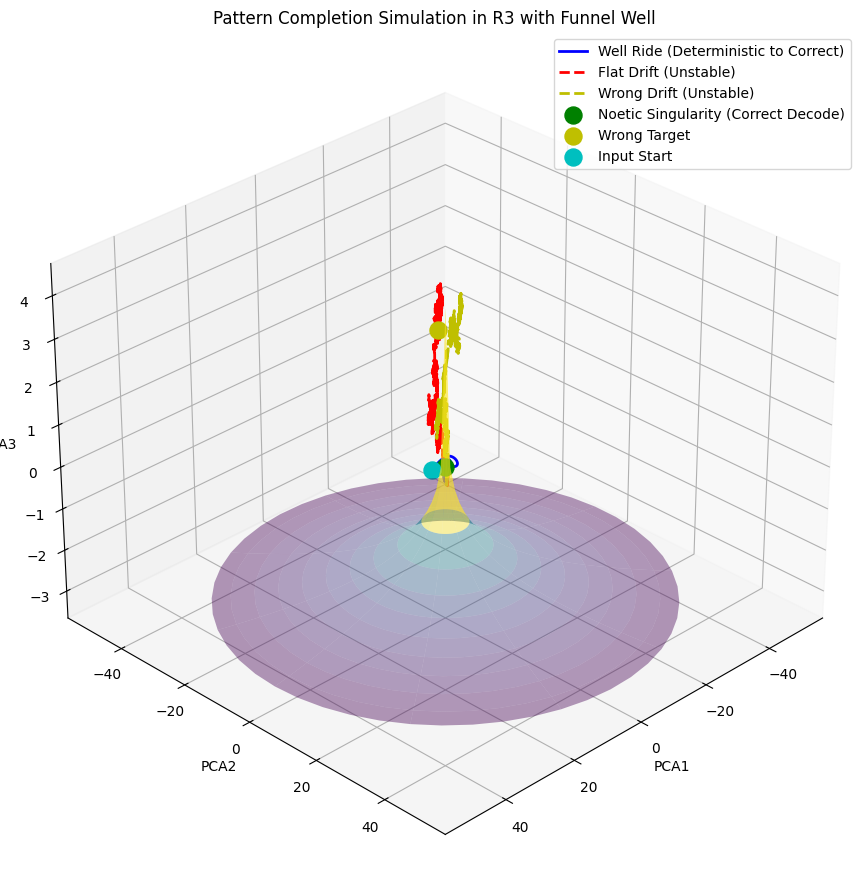

In [1]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA

# Simulate ARC-like grid transformations
def create_arc_data():
    a, b, c, d = 2, 3, 4, 5  # Sample 2x2 grid
    input_r4 = np.array([a, b, c, d])  # Initial state [2, 3, 4, 5]
    target_r4 = np.array([c, a, d, b])  # Target after 90° rotation [4, 2, 5, 3]
    wrong_r4 = np.array([d, c, b, a])  # Wrong [5, 4, 3, 2]
    return input_r4, target_r4, wrong_r4

# Project R4 to R3 for visualization (PCA on time series)
def project_to_r3(r4_data):
    pca = PCA(n_components=3)
    projected = pca.fit_transform(r4_data)  # Fit on (num_timesteps, 4)
    return projected

# Dynamic Operator: 90° clockwise rotation matrix for R4 vector
R = np.array([
    [0, 0, 1, 0],
    [1, 0, 0, 0],
    [0, 0, 0, 1],
    [0, 1, 0, 0]
])

# Geodesic equations with dynamic rotation and stabilization
def geodesic_eqs(y, t, M, r_scale, R, target, gamma):
    x, dx = y[:4], y[4:]  # R4 position and velocity
    r = np.sqrt(np.sum(x**2)) + 1e-6
    M_eff = M * (1 / (1 + r / r_scale))  # Position-dependent mass
    factor = 1 - 2 * M_eff / r
    # Acceleration: Warping toward origin + rotation + pull to target + damping
    d2x = -M_eff * x / r**3 * factor + 0.01 * (R @ x - x) + 0.2 * M_eff * (target - x) / np.linalg.norm(target - x + 1e-6) - gamma * dx
    return np.concatenate([dx, d2x])

# Parameters
M = 25.0  # Semantic mass
r_scale = 15.0  # Scale for stability
gamma = 0.1  # Damping coefficient
t = np.linspace(0, 100, 2000)  # Time range

# Initial conditions
input_r4, target_r4, wrong_r4 = create_arc_data()
y0 = np.concatenate([input_r4, [0.05, 0.05, 0.05, 0.05]])  # Initial velocity

# Solve for well path (R4 computation)
sol_well = odeint(geodesic_eqs, y0, t, args=(M, r_scale, R, target_r4, gamma))
x_well_r4 = sol_well[:, :4]
# Project to R3 for visualization
x_well_r3 = project_to_r3(x_well_r4)

# Flat space (M=0, no rotation, no target pull)
sol_flat = odeint(geodesic_eqs, y0, t, args=(0, r_scale, np.eye(4), target_r4, gamma))
x_flat_r4 = sol_flat[:, :4]
x_flat_r3 = project_to_r3(x_flat_r4)
np.random.seed(42)
noise = np.random.normal(0, 0.05, size=(len(t), 3))  # Reduced noise for subtle drift
x_flat_r3 += np.cumsum(noise, axis=0)

# Wrong path (M=0, no rotation, toward wrong target)
sol_wrong = odeint(geodesic_eqs, y0, t, args=(0, r_scale, np.eye(4), wrong_r4, gamma))
x_wrong_r4 = sol_wrong[:, :4]
x_wrong_r3 = project_to_r3(x_wrong_r4)
x_wrong_r3 += np.cumsum(noise, axis=0)

# Check convergence (deterministic ride success)
final_pos_well = x_well_r4[-1]
converged = np.all(np.abs(final_pos_well - target_r4) < 0.1)
print(f"Warped Manifold Converged to Target: {converged}")
print(f"Final Position (Well): {final_pos_well}")
print(f"Target Position: {target_r4}")

# Funnel surface (deeper logarithmic well near origin)
u = np.linspace(0, 2 * np.pi, 50)
v = np.linspace(0.01, 50, 50)  # Avoid v=0
U, V = np.meshgrid(u, v)
X = V * np.cos(U)
Y = V * np.sin(U)
Z = -20 * np.log(V + 1e-6) / (M + 1e-6)  # Deeper near origin

# Plot
fig = plt.figure(figsize=(12, 9))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z, cmap='viridis', alpha=0.4, rstride=5, cstride=5)
ax.plot(x_well_r3[:, 0], x_well_r3[:, 1], x_well_r3[:, 2], 'b-', linewidth=2, label='Well Ride (Deterministic to Correct)')
ax.plot(x_flat_r3[:, 0], x_flat_r3[:, 1], x_flat_r3[:, 2], 'r--', linewidth=2, label='Flat Drift (Unstable)')
ax.plot(x_wrong_r3[:, 0], x_wrong_r3[:, 2], x_wrong_r3[:, 2], 'y--', linewidth=2, label='Wrong Drift (Unstable)')
ax.scatter(0, 0, 0, color='g', s=150, label='Noetic Singularity (Correct Decode)')
ax.scatter(x_wrong_r3[-1, 0], x_wrong_r3[-1, 1], x_wrong_r3[-1, 2], color='y', s=150, label='Wrong Target')
ax.scatter(x_well_r3[0, 0], x_well_r3[0, 1], x_well_r3[0, 2], color='c', s=150, label='Input Start')
ax.set_xlabel('PCA1')
ax.set_ylabel('PCA2')
ax.set_zlabel('PCA3')
ax.set_title('Pattern Completion Simulation in R3 with Funnel Well')
ax.legend()
ax.view_init(elev=30, azim=45)
plt.tight_layout()
plt.savefig('pattern_completion.png')  # Save for repo
plt.show()